# What factors effect a movie's financial sucess? 

FILL IN A BRIEF DESCRIPTION??

In [35]:
%matplotlib inline 
from matplotlib import rcParams # special matplotlib argument for improved plots
from bs4 import BeautifulSoup
from collections import defaultdict 
from imdb import IMDb
from pyquery import PyQuery as pq

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
import cPickle as pickle
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

import io 
import time
import requests
import sklearn

### Scrape the movie gross Information from boxofficemojo.com 

In [20]:
years = xrange(2009,2015)
pages = xrange(1,9)
year_pagetxt = {}
for year in years: 
    pagestext = {}
    for page in pages: 
        r = requests.get("http://www.boxofficemojo.com/yearly/chart/?page=%s&view=releasedate&view2=domestic&yr=%s&p=.htm"%(page, year))
        pagestext[page] = r.text
        time.sleep(1)
    year_pagetxt[year] = pagestext
    


In [21]:
movie_budget = defaultdict(list) 
for year in years: 
    for page in pages: 
        soup = BeautifulSoup(year_pagetxt[year][page], "html.parser")
        rows = soup.find_all("font", attrs={'size':'2'})
           
        start = 10 
        for i in range(start,len(rows)-2):
            t = rows[i].get_text()
            if unicode('Summary of') in t: 
                break
            elif (i-start) % 9 == 0: 
                movie_budget['rank'].append(t)
            elif (i-start) % 9 == 1: 
                movie_budget['year'].append(year)
                r = '('+str(year)
                if unicode(r) in t: 
                    j = t.index(unicode(r))
                    movie_budget['title'].append(t[:j])
                else: 
                    movie_budget['title'].append(t)
            elif (i-start) % 9 == 2: 
                movie_budget['studio'].append(t)
            elif (i-start) % 9 == 3: 
                movie_budget['gross'].append(t)
            elif (i-start) % 9 == 4: 
                movie_budget['gross theaters'].append(t)
            elif (i-start) % 9 == 5: 
                movie_budget['opening'].append(t)
            elif (i-start) % 9 == 6: 
                movie_budget['opening theaters'].append(t)
            elif (i-start) % 9 == 7: 
                movie_budget['open'].append(t)
            elif (i-start) % 9 == 8: 
                movie_budget['close'].append(t)

###Scrape movie budget information from the-numbers.com 

In [22]:
r_numbers = requests.get("http://www.the-numbers.com/movie/budgets/all")

d_=pq(r_numbers.text)
d_tables=pq(d_('table'))
rows = pq(d_tables[0])('tr')

In [23]:
budget = defaultdict(list)
for j in range(1,len(rows)):
    dat = pq(rows[j])('td')
    for i in range(len(dat)):
        if i % 6 == 1:
            budget['year'].append(int(pq(dat[i])('a').text().split('/')[-1]))
        elif i % 6 == 2:
            t = pq(dat[i])('a').text()
            if 'Birdman' in t:
                budget['title'].append(t.split(' or ')[0])
            else:
                budget['title'].append(t)
        elif i % 6 == 3: 
            budget['budget'].append(pq(dat[i]).text())

### IMDbpy's 'search_movies' might return many movies related to our search. Our 'find_movie', finds the appropriate movie.

To get precise information from IMDBpy, you must hold the specific movieid. However, movie id's are not published anywhere. Therefore, to get an id for a given movie, you must put the title and/or year into a 'search_movie function', which returns a list of movie objects that might contain any part of your search term. To obtain id's that best matches our requested title, we wrote a function 'find_movie', which returns the movie that is most similar to our desired title. 

In [24]:
def find_movie(title, year,  movie_list):
    """
    find_movie: given the movie title (type: string) that you desire, 
    the year (type:int) that your desired movie came out, and a list of 
    movies (type:list containing imdbpy movie objects), this functon will 
    return the movie object that has a title that best matches yours. 
    If there are no plausible matches, it will return None. 
    """
    # find movies that came out in the same year                                                                                                                                    
    year_list = []
    for movie in movie_list:
        try:
            if movie.data['year'] == int(year):
                year_list.append(movie)
        except:
            continue
    # if the years do not match, there is no match                                                                                                                                  
    if len(year_list) < 1:
        return None
    else:
        # process the desired title                                                                                                                                                         
        sorted_title = "".join(sorted(title)).replace(" ", "")
        len_sorted_title = len(sorted_title)
        # check whether movies that came out in the same year contain the same letters                                                                                                                      
        counts = [0]*len(year_list)
        for j in range(len(year_list)):
            # process each movie title 
            movie_title = year_list[j]['title']
            sorted_movie_title = "".join(sorted(movie_title)).replace(" ", "")
            if len_sorted_title == len(sorted_movie_title):
                # if the title cannot be converted to a string it is not the correct title                                                                                                                                       
                try:
                    sorted_movie_title = str(sorted_movie_title)
                except:
                    continue
                for i in range(len_sorted_title):
                    if sorted_title[i].lower() == sorted_movie_title[i].lower():
                        counts[j] += 1
            else:
                continue
        
        if max(counts) <= len_sorted_title: 
            k = counts.index(max(counts))
        else: 
            k = counts.index(len_sorted_title)
        if len(year_list) >= 1:
            return year_list[k]
        else:
            return None

### Combine movie ids, budget info, and gross info into one dictionary, BOdict 

Note: This script takes 2-3 hours to complete. 

In [27]:
# instantiate an IMDB object 
ia = IMDb(accessSystem='http')

BOmissingmovies = [] # Tracks movies that we cannot find a match for 
BOdict = {} # Contains movie information 
movienumber = len(movie_budget['year'])

for i in range(movienumber):
    movieobj = None
    # Need to process the row-level information out of BOdf in order to get the movie objects
    movieobj = ia.search_movie(movie_budget['title'][i])
    
    #Handling cases where we haven't found the movie or have multiples
    if movieobj is None or len(movieobj)>1:
        potential_movie_titles = ia.search_movie(movie_budget['title'][i])
        movieobj = find_movie(movie_budget['title'][i], movie_budget['year'][i], potential_movie_titles) # find the movie
        if type(movieobj) == list: 
            movieobj = movieobj[0]
    
    if movieobj is not None and not (type(movieobj) == list and len(movieobj) == 0):
        ## Get movie id ##
        if type(movieobj) == list: 
            movieobj = movieobj[0]
        ia.update(movieobj)    
        movid = movieobj.movieID
        ## Populate dictionary, main key is movie id ##
        BOdict[movid] = {}
        # "title": title of movie
        BOdict[movid]['title'] = movie_budget['title'][i]
        BOdict[movid]['gross'] = float(movie_budget['gross'][i][1:].replace(',',''))
        BOdict[movid]['opening'] = float(movie_budget['opening'][i][1:].replace(',',''))
        BOdict[movid]['rank'] = movie_budget['rank'][i]
        BOdict[movid]['studio'] = movie_budget['studio'][i] 
        BOdict[movid]['open'] = movie_budget['open'][i]
        BOdict[movid]['close'] = movie_budget['close'][i]
        BOdict[movid]['opening theaters'] = float(movie_budget['opening theaters'][i])
        BOdict[movid]['year'] = movie_budget['year'][i]
        try:
            BOdict[movid]['rating'] = movieobj['rating']
        except: 
            BOdict[movid]['rating'] = None
        try:
            BOdict[movid]['mpaa'] = movieobj['mpaa']
        except: 
            BOdict[movid]['mpaa'] = None
        try:
            BOdict[movid]['director'] = None
        except: 
            BOdict[movid]['director'] = None
        try:
            BOdict[movid]['cast'] = None
        except:
            BOdict[movid]['cast'] = None
    else:
        BOmissingmovies.append((i, movie_budget['title'][i], movie_budget['year'][i]))

In [ ]:
# Add feature describing which season the movie was released in 
for k in BOdict.keys():
    open_date = BOdict[k]['open']
    if open_date:
        month = int(open_date.split('/')[0])
        if month <= 5 and month >= 1:
            BOdict[k]['season'] = 'Jan-May'
        elif month <= 9 and month >= 6:
            BOdict[k]['season'] = 'June-Sep'
        elif month <= 11 and month >= 10:
            BOdict[k]['season'] = 'Oct-Nov'
        elif month == 12: 
            BOdict[k]['season'] = 'Dec'
        else:
            BOdict[k]['season'] = None 

In [ ]:
# Add feature describing the movies budget 
c = 0
for k in BOdict.keys():
    for i in range(len(budget['title'])):
        if sorted(unicode(budget['title'][i].lower().replace(' ', ''))) == sorted(BOdict[k]['title'].lower().replace(' ','')):
            BOdict[k]['budget'] = float(budget['budget'][i][1:].replace(',',''))
            break
        else:
            BOdict[k]['budget'] = None 

In [ ]:
# Since this took a long time to run, we save it here to ensure it is available for later use. 
pickle.dump(BOdict, io.open('BOdict.p', 'wb'))

In [28]:
BOdict = pickle.load(io.open('BOdict.p', 'rb'))

### Exploratory Data Analysis

In [31]:
BOdf = pd.DataFrame(BOdict).transpose()
print BOdf.shape
BOdf.head()

(3088, 15)


,budget,cast,close,director,gross,mpaa,open,opening,opening theaters,rank,rating,season,studio,title,year
0035429,None,None,11/17,None,"$47,214",None,5/20,"$7,849",1,406,7.6,0,Rialto,Went The Day Well?,2011
0049877,None,None,6/6,None,"$18,297",None,5/24,"$9,997",1,511,7.5,0,Rialto,A Pig Across Paris,2013
0054758,None,None,-,None,"$50,039",Rated PG-13 for violence,6/12,"$10,217",1,364,6.6,1,FDesk,Le combat dans l'île (1962),2009
0055082,None,None,9/17,None,"$27,567",None,4/17,"$9,515",1,405,7.8,0,Rialto,"Leon Morin, Priest",2009
0067409,None,None,-,None,"$35,387",None,8/10,"$11,264",1,445,7.4,1,Rialto,Max et les Ferrailleurs (Max and the Junkmen),2012


In [32]:
limiteddf = BOdf.dropna(subset=['budget', 'season', 'mpaa', 'opening'])
limiteddf.head()

,budget,cast,close,director,gross,mpaa,open,opening,opening theaters,rank,rating,season,studio,title,year
0327597,60000000,None,7/2,None,"$75,286,229","Rated PG for thematic elements, scary images, ...",2/6,"$16,849,640","2,299",43,7.7,0,Focus,Coraline,2009
0337692,25000000,None,5/24,None,"$92,476","Rated R for strong sexual content, drug use an...",5/11,"$56,692",50,372,6.1,0,Free,The Road,2012
0359950,91000000,None,4/10,None,"$58,236,838","Rated PG for some crude comments, language and...",12/25,"$12,765,508","2,909",60,7.4,3,Fox,The Secret Life of Walter Mitty,2013
0361748,70000000,None,12/17,None,"$120,540,719","Rated R for strong graphic violence, language ...",8/21,"$38,054,676","3,165",25,8.3,1,Wein.,Inglourious Basterds,2009
0362478,25000000,None,1/7,None,"$15,051,977","Rated PG-13 for thematic elements, some violen...",11/6,"$7,571,417","2,635",125,5.6,2,WB,The Box,2009


In [38]:
# remove this later 
limiteddf['gross'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
limiteddf['opening'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
limiteddf['opening theaters'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')
#
limiteddf.loc[limiteddf['opening']=='']  = 0
limiteddf.loc[limiteddf['opening theaters']=='']  = 0

# remove 
limiteddf['gross'] = limiteddf['gross'].astype(float)
limiteddf['opening'] = limiteddf['opening'].astype(float)
limiteddf['opening theaters'] = limiteddf['opening theaters'].astype(float)
limiteddf['budget'] = limiteddf['budget'].astype(float)
#

/Users/dhanus/anaconda/lib/python2.7/site-packages/pandas/core/common.py:516: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x
/Users/dhanus/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/dhanus/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/dhanus/anaconda/lib/python2.7/site-pac

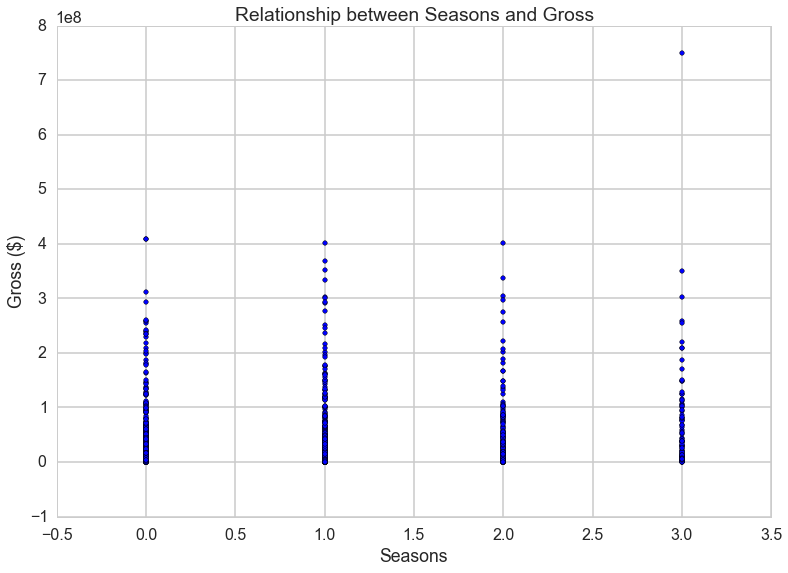

In [40]:
plt.scatter(limiteddf.season, limiteddf.gross)
plt.xlabel("Seasons")
plt.ylabel("Gross ($)")
plt.title("Relationship between Seasons and Gross")

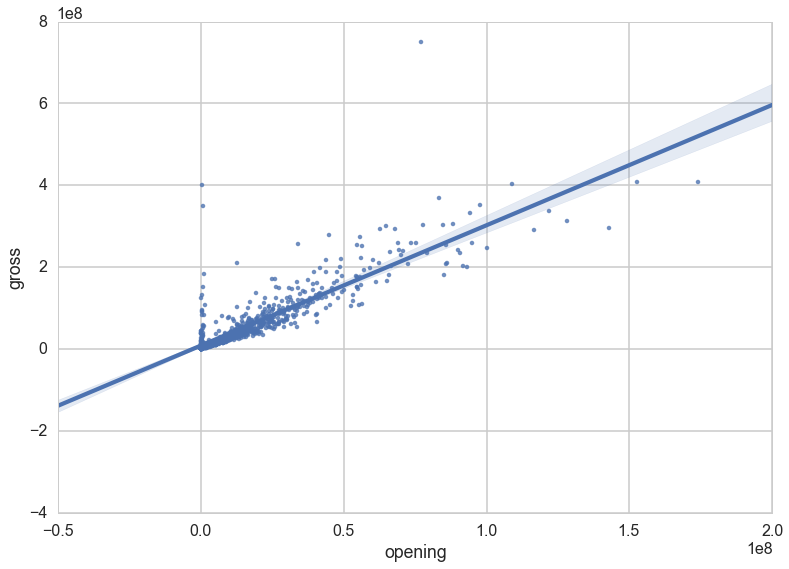

In [41]:
sns.regplot(y="gross", x="opening", data=limiteddf, fit_reg = True)

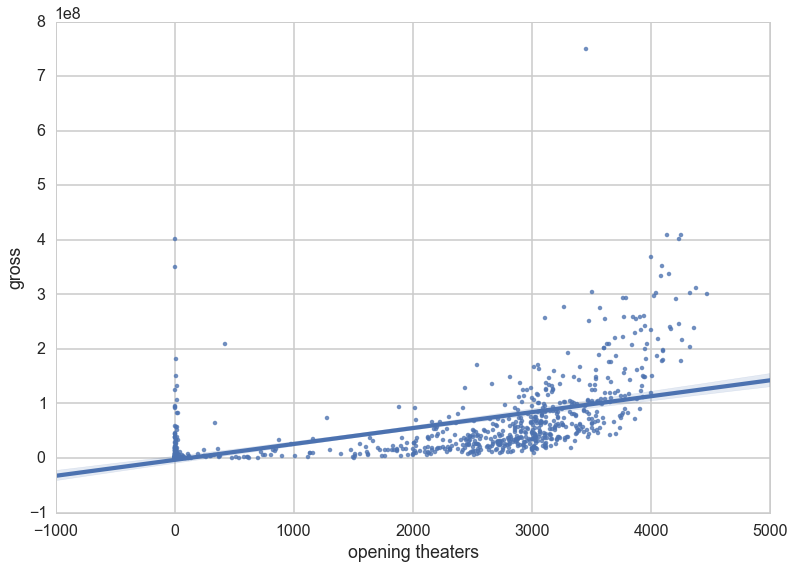

In [42]:
sns.regplot(y="gross", x="opening theaters", data=limiteddf, fit_reg = True)

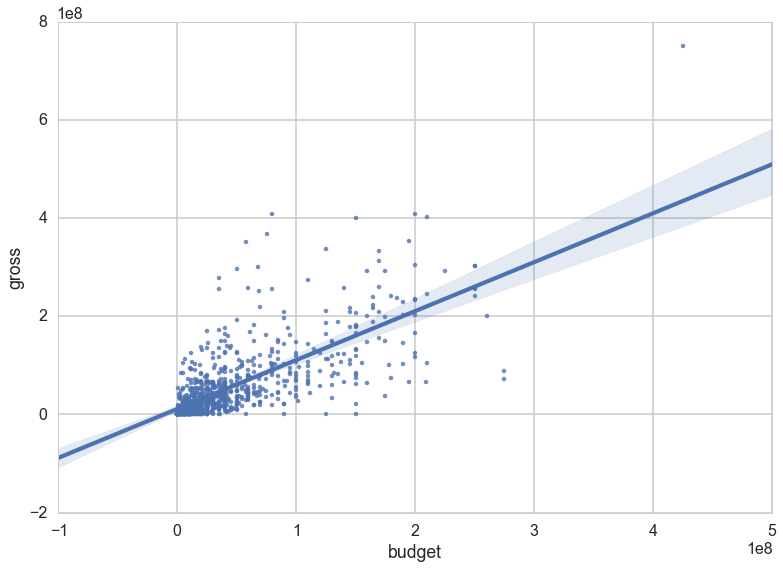

In [43]:
sns.regplot(y="gross", x="budget", data=limiteddf, fit_reg = True)

In [ ]:
from statsmodels.formula.api import ols
m = ols('gross ~ budget + opening_theaters + season',limiteddf).fit()
print m.summary()

In [ ]:
m2 = ols('gross ~ budget + opening_theaters + opening_gross + season',limiteddf).fit()
print m2.summary()

In [ ]:
plt.scatter(limiteddf['gross'], m.fittedvalues)
plt.xlabel("Gross: $Y_i$")
plt.ylabel("Predicted Gross: $\hat{Y}_i$")
plt.title("Gross vs Predicted Gross: $Y_i$ vs $\hat{Y}_i$ Model 1")

In [ ]:
plt.scatter(limiteddf['gross'], m2.fittedvalues)
plt.xlabel("Gross: $Y_i$")
plt.ylabel("Predicted Gross: $\hat{Y}_i$")
plt.title("Gross vs Predicted Gross: $Y_i$ vs $\hat{Y}_i$ Model 2")